In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
import string
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import SnowballStemmer

In [2]:
df = pd.read_csv("../data/Youtube-Spam-Dataset.csv")

In [3]:
df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


In [4]:
df_copy = df[['CONTENT', 'CLASS']]
df_copy.head()

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


## 
1 : label SPAM
0 : label HAM

In [5]:
label_counts = df_copy['CLASS'].value_counts()
label_counts

CLASS
1    1005
0     951
Name: count, dtype: int64

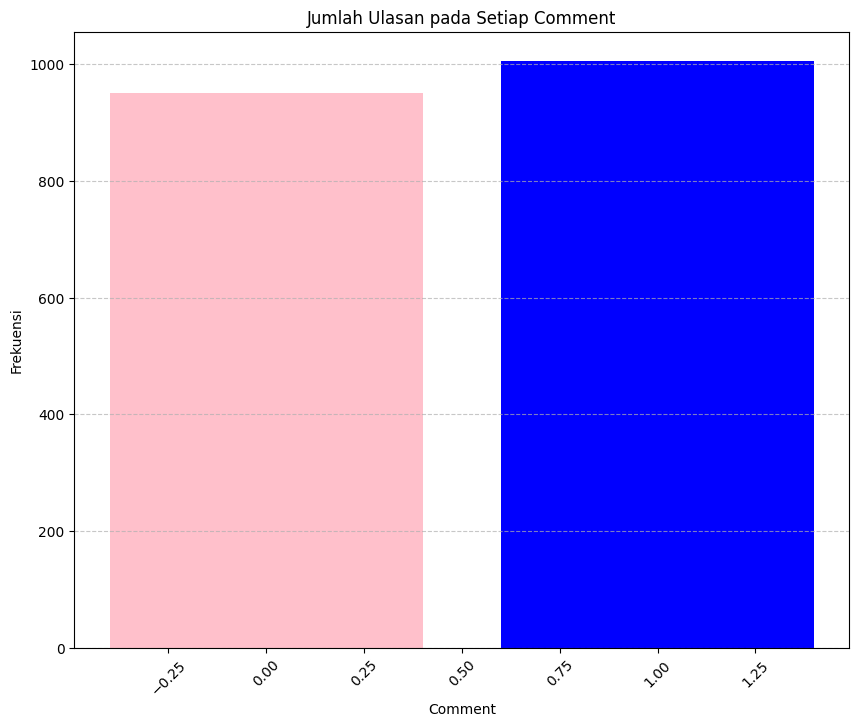

In [6]:
plt.figure(figsize=(10,8))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'pink'])
plt.xlabel('Comment')
plt.ylabel('Frekuensi')
plt.title('Jumlah Ulasan pada Setiap Comment')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Text Processing

## Lower Case

In [7]:
df_copy['content_lowercase'] = df_copy['CONTENT'].str.lower()
df_copy.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17832\1627129950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_lowercase'] = df_copy['CONTENT'].str.lower()


,CONTENT,CLASS,content_lowercase
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿


## Cleaning text

In [18]:
def remove_noise_0(text):
    '''Remove unwanted characters, HTML tags, URLs, non-ASCII symbols, and spam-like content to clean the text'''
    
      # Step 1: Initial cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Step 2: Fix spaced domains BEFORE URL detection (critical for accuracy)
    text = re.sub(r'([a-zA-Z0-9_-]+)\s*\.\s*(com|net|org|id|co|uk|info|biz)\b', r'\1.\2', text)
    
    # Step 3: Decode HTML entities
    text = html.unescape(text)
    
    # Step 4: Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Step 5: PRESERVE spam indicators as features (critical for ML)
    text = re.sub(r'!{2,}', ' EXCLAMATION_SPAM ', text)
    text = re.sub(r'\?{2,}', ' QUESTION_SPAM ', text)
    text = re.sub(r'\.{3,}', ' DOTS_SPAM ', text)
    
    # Step 6: URL detection (MOST IMPORTANT - 25.9x spam signal)
    # Comprehensive URL patterns found in dataset
    text = re.sub(r'\b(?:https?:?\/?\/|http:?\/?\/|www\.)\S+', ' URL ', text)
    text = re.sub(r'watch\?v=\S+', ' URL ', text)  # YouTube videos
    text = re.sub(r'\b[a-zA-Z0-9_-]+\.(com|net|org|id|co|uk)\b', ' URL ', text)
    text = re.sub(r'\b(?:bit|adf|tinyurl|rebrand|shorturl|is\.gd|shorte|cutt|t\.co|lnkd)\.(?:ly|me|com|co|gd|io)\S*', ' URL ', text)
    
    # Step 7: Email and crypto detection
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAIL_ADDRESS ', text)
    text = re.sub(r'\b[a-zA-Z0-9]{25,}\b', ' CRYPTO_ADDRESS ', text)
    
    # Step 8: EMOTICON handling (single token approach - more effective)
    text = re.sub(r'([:;=xX8][-~^]?[)\]dDpP3]|[:;=xX8][-~^]?[([\\/]|[:;=xX8][-~^]?[oO|]|\^_?\^|>_?<|-_-|o_O|O_o|<3)', ' EMOTICON ', text)
    
    # Step 9: Character normalization
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove BOM and non-ASCII
    text = re.sub(r'[^a-zA-Z0-9\s_]', ' ', text)  # Keep only alphanumeric + spaces + underscores
    text = re.sub(r'([a-zA-Z])\1{3,}', r'\1\1', text)  # Normalize repeated chars
    
    # Step 10: NUMBER handling (single NUM token)
    text = re.sub(r'\b\d+', 'NUM', text)
    
    # Step 11: Token consolidation (prevent feature explosion)
    tokens_to_consolidate = ['EXCLAMATION_SPAM', 'QUESTION_SPAM', 'DOTS_SPAM', 'URL', 'EMAIL_ADDRESS', 'CRYPTO_ADDRESS', 'EMOTICON', 'NUM']
    for token in tokens_to_consolidate:
        text = re.sub(rf'\b({token})(\s+\1)+\b', r'\1', text)
    
    # Step 12: Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# RegEx (Regular Expression)

sequence of characters that forms a search pattern. used to check if a string contains the specified search pattern.

RegEx module in python re

## RegEx Function
- findall: Returns a list containing all matches
- search: Returns a Macth object if there is a match anywhere in the string
- split: Returns a list where the string has been split at each match
- sub: replaces one or many mathces with a string


## penjelasan code
- ```python
  re.sub(r'https://\S+', ' https ', text)
  ```
  Mengganti semua link `https://` dalam sebuah teks dengan kata `' https '`.

- ```python
  re.sub(r'http://\S+', ' http ', text)
  ```
  Mengganti semua link `http://` dalam sebuah teks dengan kata `' http '`.

- ```python
  re.sub(r'www\.\S+', ' url ', text)
  ```
  Mengganti semua link yang dimulai dengan `www.` dalam sebuah teks dengan kata `' url '`.

- ```python
    re.sub(r'<[^>]*>', ' ', text) 
    ```
    menghapus tag html dari sebuah text. `[^>]` mencocokkan sembarang karakter kecuali > sebanyak mungkin (isi dalam tag). 

- ```python
    re.sub(r'&amp;', '', text)
    ```
    menghapus entitas HTML `&amp;` dari teks. `r'&amp;` merupakan pola regex yang mencocokkan teks `&amp;`,, yaitu entitas HTML untuk karakter `&` (ampersand)

- ```python
    re.sub(r'[_"\-;%()|+&=*%.,!?:#$@^\[\]/]', ' ', text) 
    ```
    remove special characters

- ```python
    re.sub(r'\'', ' ', text)
    ```
    membersihkan teks dari tanda petik satu

- ```python
   re.sub(r'[^\x00-\x7F]+', ' ', text)
   ```
   menghapus seluruh karakter nin-ASCII dari teks, termasuk karakter rusak atau simbol asing yang tifak termasuk dalam standar ASCII.
    `\x00` sampai `\x7F` adalah rentang **karakter ASCII standar**, yaitu:
    - Huruf: `A-Z`, `a-z`
    - Angka: `0-9`
    - Simbol umum: `. , ! ? ( ) @ #` dan sebagainya
    - Spasi dan karakter kontrol seperti **tab** dan **newline**
    - `[^...]` : berarti **bukan** karakter dalam rentang tersebut (karakter yang berada di luar ASCII standar)
    - `[^\x00-\x7F]+` : berarti **satu atau lebih karakter** yang **bukan ASCII standar**

- ```python
    text = re.sub(r'(\W)\1+', r'\1', text) 
    ```
    menghapus pengulangan karakter non-huruf/angka yang sama secara berurutan, dan hanya menyisakan satu karakter saja.

    | Bagian | Arti |
    |--------|------|
    | `(\W)` | Menangkap satu karakter non-word: bukan huruf, angka, atau underscore. Contoh: `!`, `@`, `#`, spasi |
    | `\1+`  | Mencocokkan satu atau lebih pengulangan karakter yang sama seperti yang ditangkap oleh `(\W)` |
    | `r'\1'` | Mengganti seluruh pengulangan itu dengan satu karakter saja |
    


In [8]:
def remove_noise(text):
    '''Remove unwanted characters, HTML tags, URLs, non-ASCII symbols, and spam-like content to clean the text'''
    
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip() 

    # Hapus spasi berlebih dan ubah jadi satu kalimat
    #text_single_line = re.sub(r'\s+', ' ', text_fixed).strip()
    # Handle spaced domains BEFORE general URL detection
    # "kidsmediausa .com" → "kidsmediausa.com" (more targeted)
    text = re.sub(r'([a-zA-Z0-9_-]+)\s*\.\s*(com|net|org|id|co|uk|info|biz)\b', r'\1.\2', text)
    

    # Gabungkan pola "nama . com" menjadi "nama.com"
    text = re.sub(r'(\w+)\s*\.\s*(com|net|org|id|co)', r'\1.\2', text)

    #Decode HTML entities like &amp;, &lt;, &gt;
    text = html.unescape(text)
    
    # Ganti angka ordinal seperti 11th, 1st, 22nd → 'num'
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'num', text)
    
    # Deteksi alamat wallet atau string acak panjang (biasanya spam/crypto) → 'cryptoaddr'
    text = re.sub(r'\b[a-zA-Z0-9]{25,}\b', 'cryptoaddr', text)

    # Ganti email dengan token
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' email ', text)
    
    # Deteksi dan ganti semua bentuk URL tersamar dan eksplisit menjadi 'url'
    # Ganti semua bentuk URL menjadi 'url' secara global hanya sekali
    text = re.sub(
       r'''(?ix)  # ignore case, allow verbose
        \b(?:https?:?/?/?|http:?/?/?|www\.)           # http://, https://, http:/, www.
        [\w\-]+(\.[\w\-.]+)+                           # domain dan subdomain
        (/[^\s]*)?                                     # path opsional
        |
        \b(?:bit|adf|tinyurl|rebrand|shorturl|is\.gd|shorte|cutt|t\.co|lnkd)
        \.(?:ly|me|com|co|gd|io)(/\S*)?
        |
        watch\?v=\S+
        ''',
        'url',
        text
    )
    
    # Remove all HTML tags, including <a href="...">...</a>
    text = re.sub(r'<[^>]*>', ' ', text)  # Matches any text within <...>
    
    # Hapus emotikon seperti :) :p :( :D :-P dll
    text = re.sub(r'[:;=xX8][-~^]?[)(dDPpOo3|/\\]', ' ', text)

    # Gabungkan huruf yang dipisah strip, contoh: d-d-d-d-d-d → dddddd
    text = re.sub(r'\b([a-zA-Z])(?:-[a-zA-Z])+\b', lambda m: m.group(0).replace('-', ''), text)

   # Gabungkan huruf-huruf tunggal yang terpisah oleh spasi, misalnya "p e a c e" → "peace"
    text = re.sub(r'\b(?:[a-zA-Z] ){1,}[a-zA-Z]\b', lambda m: m.group(0).replace(' ', ''), text)

   
    # Hapus semua karakter selain huruf, angka, dan spasi
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


    # Remove BOM and all non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Removes characters like ï»¿ or emojis
    
    # Remove repetitive symbols (e.g., â–Œ repeated multiple times)
    text = re.sub(r'(\W)\1+', r'\1', text)  # Replace repeated non-word characters with a single one

    # Ganti semua angka (termasuk angka besar, desimal, dan notasi ilmiah) menjadi token 'num'
    text = re.sub(r'\b(?:\d{1,3}(?:,\d{3})+|\d+(?:\.\d+)?|\d+x\d+\^?\d*)\b', 'num', text)

    # Gabungkan token 'num' berulang agar hanya muncul sekali
    text = re.sub(r'\b(num)(\s+\1)+\b', r'\1', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text


In [11]:
import re
import html

def remove_noise1(text):
    '''Remove unwanted characters while preserving important features for spam/ham classification'''
    
    if not text or pd.isna(text):
        return ''
    
    text = str(text)
    
    # Decode HTML entities like &amp;, &lt;, &gt;
    text = html.unescape(text)
    
    # Remove HTML tags first
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Handle spaced domains BEFORE general URL detection
    # "kidsmediausa .com" → "kidsmediausa.com" (more targeted)
    text = re.sub(r'([a-zA-Z0-9_-]+)\s*\.\s*(com|net|org|id|co|uk|info|biz)\b', r'\1.\2', text)
    
    # Preserve excessive punctuation as spam indicator (convert to token)
    # "!!!" → "EXCLAMATION_SPAM", "???" → "QUESTION_SPAM"  
    text = re.sub(r'!{2,}', ' EXCLAMATION_SPAM ', text)
    text = re.sub(r'\?{2,}', ' QUESTION_SPAM ', text)
    text = re.sub(r'\.{3,}', ' DOTS_SPAM ', text)
    
    # Replace URLs with contextual tokens (preserve the spam signal)
    # Full URLs
    text = re.sub(
        r'''(?ix)
        \b(?:https?:?/?/?|http:?/?/?|www\.)
        [\w\-]+(\.[\w\-.]+)+
        (/[^\s]*)?
        ''',
        ' URL ',
        text
    )
    
    # Shortened URLs
    text = re.sub(
        r'\b(?:bit|adf|tinyurl|rebrand|shorturl|is\.gd|shorte|cutt|t\.co|lnkd)\.(?:ly|me|com|co|gd|io)(?:/\S*)?',
        ' URL ',
        text
    )
    
    # YouTube video links
    text = re.sub(r'watch\?v=\S+', ' URL ', text)
    
    # Domain-only patterns (common in spam)
    text = re.sub(r'\b[a-zA-Z0-9_-]+\.(?:com|net|org|id|co|uk)\b', ' URL ', text)
    
    # Replace emails with token
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAIL_ADDRESS ', text)
    
    # Crypto/wallet addresses (long random strings)
    text = re.sub(r'\b[a-zA-Z0-9]{25,}\b', ' CRYPTO_ADDRESS ', text)
    
    # Replace ordinal numbers
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'NUM_ORDINAL', text)
    
    # Replace various number formats with more specific tokens
    text = re.sub(r'\b\d{1,3}(?:,\d{3})+\b', 'NUM_LARGE', text)  # 1,000,000
    text = re.sub(r'\b\d+\.\d+\b', 'NUM_DECIMAL', text)  # 3.14
    text = re.sub(r'\b\d+x\d+\b', 'NUM_DIMENSION', text)  # 1920x1080
    text = re.sub(r'\b\d+\b', 'NUM', text)  # remaining numbers
    
    # Handle emoticons (preserve sentiment info)
    # Positive emoticons
    text = re.sub(r'[:;=xX8][-~^]?[)\]dDpP]', ' HAPPY_EMOTICON ', text)
    # Negative emoticons  
    text = re.sub(r'[:;=xX8][-~^]?[([\\/]', ' SAD_EMOTICON ', text)
    # Neutral/other emoticons
    text = re.sub(r'[:;=xX8][-~^]?[oO|]', ' NEUTRAL_EMOTICON ', text)
    
    
    # Remove repetitive symbols (e.g., â–Œ repeated multiple times)
    text = re.sub(r'(\W)\1+', r'\1', text)  # Replace repeated non-word characters with a single one

    # Hapus emotikon seperti :) :p :( :D :-P dll
    text = re.sub(r'[:;=xX8][-~^]?[)(dDPpOo3|/\\]', ' ', text)

    # Fix separated letters but preserve intentional spacing for emphasis
    # "d-d-d-d" → "dddd" (stammering pattern)
    text = re.sub(r'\b([a-zA-Z])-([a-zA-Z])-([a-zA-Z]+(?:-[a-zA-Z])*)\b', 
                  lambda m: m.group(0).replace('-', ''), text)
    
    # "p e a c e" → "peace" but only if it's clearly unintentional
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z]+(?:\s+[a-zA-Z])*)\b',
                  lambda m: m.group(0).replace(' ', ''), text)
    
    # Remove BOM and problematic Unicode
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    
    # Remove BOM and all non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Removes characters like ï»¿ or emojis
    
    # Clean up excessive special characters (but keep our tokens)
    # Remove everything except letters, numbers, spaces, and our preserved tokens
    text = re.sub(r'[^a-zA-Z0-9\s_]', ' ', text)
    
    # Normalize repeated characters (but preserve our spam indicators)
    # "hellooooo" → "helloo" (reduce but don't eliminate completely)
    text = re.sub(r'([a-zA-Z])\1{3,}', r'\1\1', text)
    
    # Consolidate multiple instances of our tokens
    text = re.sub(r'\b(EXCLAMATION_SPAM)(\s+\1)+\b', r'\1', text)
    text = re.sub(r'\b(QUESTION_SPAM)(\s+\1)+\b', r'\1', text)
    text = re.sub(r'\b(DOTS_SPAM)(\s+\1)+\b', r'\1', text)
    text = re.sub(r'\b(NUM)(\s+\1)+\b', r'\1', text)
    
    # Final whitespace cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [12]:
import re
import html
import pandas as pd

def remove_noise2(text):
    '''
    Comprehensive text cleaning for spam/ham classification.
    Removes noise while preserving important features for ML models.
    '''
    
    # Handle empty or null values
    if not text or pd.isna(text):
        return ''
    
    text = str(text)
    
    # Step 1: Decode HTML entities
    text = html.unescape(text)
    
    # Step 2: Fix spaced domains BEFORE URL detection
    text = re.sub(r'([a-zA-Z0-9_-]+)\s*\.\s*(com|net|org|id|co|uk|info|biz)\b', r'\1.\2', text)
    
    # Step 3: Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Hapus semua karakter selain huruf, angka, dan spasi
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)


    # Step 4: Preserve spam indicators as tokens
    text = re.sub(r'!{2,}', ' EXCLAMATION_SPAM ', text)
    text = re.sub(r'\?{2,}', ' QUESTION_SPAM ', text)
    text = re.sub(r'\.{3,}', ' DOTS_SPAM ', text)
    
    # Step 5: Replace URLs with tokens
    text = re.sub(
        r'''(?ix)
        \b(?:https?:?/?/?|http:?/?/?|www\.)
        [\w\-]+(\.[\w\-.]+)+
        (/[^\s]*)?
        |
        \b(?:bit|adf|tinyurl|rebrand|shorturl|is\.gd|shorte|cutt|t\.co|lnkd)
        \.(?:ly|me|com|co|gd|io)(?:/\S*)?
        |
        watch\?v=\S+
        |
        \b[a-zA-Z0-9_-]+\.(?:com|net|org|id|co|uk)\b
        ''',
        ' URL ',
        text
    )
    
    # Step 6: Replace emails and crypto addresses
    text = re.sub(r'\b[\w.-]+@[\w.-]+\.\w+\b', ' EMAIL_ADDRESS ', text)
    text = re.sub(r'\b[a-zA-Z0-9]{25,}\b', ' CRYPTO_ADDRESS ', text)

    # Handle emoticons - convert all to single EMOTICON token
    text = re.sub(r'([:;=xX8][-~^]?[)\]dDpP3]|[:;=xX8][-~^]?[([\\/]|[:;=xX8][-~^]?[oO|]|\^_?\^|>_?<|-_-|o_O|O_o|<3)', ' EMOTICON ', text)

    # Step 9: Fix separated characters
    text = re.sub(r'\b([a-zA-Z])-([a-zA-Z])-([a-zA-Z]+(?:-[a-zA-Z])*)\b',
                  lambda m: m.group(0).replace('-', ''), text)
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z]+(?:\s+[a-zA-Z])*)\b',
                  lambda m: m.group(0).replace(' ', ''), text)
    
    # Step 10: Remove non-ASCII and special characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'(\W)\1+', r'\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s_]', ' ', text)
    
    # Step 11: Normalize repeated characters
    text = re.sub(r'([a-zA-Z])\1{3,}', r'\1\1', text)

    # Ganti angka ordinal seperti 11th, 1st, 22nd → 'num'
    text = re.sub(r'\b\d+(st|nd|rd|th)\b', 'num', text)
    # Ganti semua angka (termasuk angka besar, desimal, dan notasi ilmiah) menjadi token 'num'
    text = re.sub(r'\b(?:\d{1,3}(?:,\d{3})+|\d+(?:\.\d+)?|\d+x\d+\^?\d*)\b', 'num', text)

    # Step 12: Consolidate duplicate tokens
    for token in ['EXCLAMATION_SPAM', 'QUESTION_SPAM', 'DOTS_SPAM', 'num', 'URL', 'EMAIL_ADDRESS']:
        text = re.sub(rf'\b({token})(\s+\1)+\b', r'\1', text)
    
    # Step 13: Final cleanup
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [24]:
print(remove_noise2("marketglory . com/strategygame/andrijamatf earn real money from game"))

marketglory com strategygame andrijamatf earn real money from game


In [20]:
df_copy['content_lowercase_rn'] = df_copy['content_lowercase'].apply(remove_noise)
df_copy.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20424\2536906138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_lowercase_rn'] = df_copy['content_lowercase'].apply(remove_noise)


,CONTENT,CLASS,content_lowercase,content_lowercase_rn
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out


## Tokenization

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Force download
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
def word_tokenization(text):
  return word_tokenize(text)

In [22]:
df_copy['content_tokenization'] = df_copy['content_lowercase_rn'].apply(word_tokenization)
df_copy.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20424\1013880177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['content_tokenization'] = df_copy['content_lowercase_rn'].apply(word_tokenization)


,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say murdev com,"[just, for, test, i, have, to, say, murdev, com]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ..."
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]"


## Normalization

In [17]:
import urbandictionary as ud

In [18]:
def dapatkan_definisi_urban(text):
    """
    Fungsi untuk mencari definisi kata di Urban Dictionary.
    Mengembalikan list dari objek definisi atau list kosong jika tidak ditemukan.
    """
    try:
        definisi_list = ud.define(text)
        return definisi_list
    except Exception as e:
        # print(f"  Error saat mencari '{kata}': {e}") # Mungkin Anda tidak ingin print error di sini
        return []

In [23]:
list_token_bersih = ["omg", "yeet", "cringe", "lit", "cap"] # Contoh daftar token bersih

print(f"Daftar Token Bersih: {list_token_bersih}")
print("-" * 30)

Daftar Token Bersih: ['omg', 'yeet', 'cringe', 'lit', 'cap']
------------------------------


In [ ]:
# Fungsi normalisasi yang mendukung list
def normalized(text): 
    if isinstance(text, list):
        # Jika input adalah list, normalisasi setiap elemen
        return [
            ''.join(
                c for c in unicodedata.normalize('NFD', term)
                if unicodedata.category(c) != 'Mn'
            ) for term in text
        ]
    elif isinstance(text, str):
        # Jika input adalah string, normalisasi langsung
        return ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
    else:
        raise TypeError("Input must be a string or a list of strings.")


In [27]:
english_slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "thx": "thanks",
    "thanx": "thanks",
    "pls": "please",
    "plz": "please",
    "omg": "oh my god",
    "idk": "i do not know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "lmk": "let me know",
    "brb": "be right back",
    "ttyl": "talk to you later",
    "btw": "by the way",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "np": "no problem",
    "tbh": "to be honest",
    "b4": "before",
    "bc": "because",
    "cuz": "because",
    "tho": "though",
    "nite": "night",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "lemme": "let me",
    "gimme": "give me",
    "outta": "out of",
    "kinda": "kind of",
    "sorta": "sort of",
    "ain't": "is not",
    "ya'll": "you all",
    "omw": "on my way",
    "ikr": "i know right",
    "idc": "i do not care",
    "bff": "best friend forever",
    "fyi": "for your information",
    "gr8": "great",
    "bday": "birthday",
    "nvm": "never mind",
    "msg": "message",
    "sec": "second",
    "pic": "picture",
    "vid": "video",
    "bio": "biography",
    "dm": "direct message",
    "jk": "just kidding",
    "afaik": "as far as i know",
    "bruh": "brother",
    "sus": "suspicious",
    "yo": "hey",
    "wassup": "what is up",
    "sup": "what is up",
    "meh": "whatever",
}


In [22]:
# Menerapkan fungsi normalisasi pada DataFrame
df_copy["content_normalized"] = df_copy['content_tokenization'].apply(normalized)
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_normalized
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, out, this, you, tube, cha..."
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, out, my, new, channel, and,..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say url,"[just, for, test, i, have, to, say, url]","[just, for, test, i, have, to, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ...","[me, shaking, my, sexy, ass, on, my, channel, ..."
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check, this, out]"


## Stopword removal

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
nltk.download('stopwords')

def remove_stopwords(text): 
    """Menghapus stopword dari list kata yang diberikan."""
    stops = set(stopwords.words("english"))
    
    if isinstance(text, list):
        text = [w for w in text if w.lower() not in stops]
        
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
df_copy['content_stopword'] = df_copy['content_tokenization'].apply(remove_stopwords)
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy EMO...,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy, EMOTICON]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]"


In [25]:
import urbandictionary as ud # atau cara impor yang sesuai untuk pustaka Anda

def dapatkan_definisi_urban(text):
    """
    Mencari definisi kata di Urban Dictionary.
    Mengembalikan objek definisi pertama jika ditemukan, jika tidak None.
    """
    try:
        definisi_list = ud.define(text)
        if definisi_list:
            return definisi_list[0] # Ambil definisi pertama
        return None
    except Exception as e:
        # print(f"Error mencari '{kata}': {e}") # Hati-hati jika terlalu banyak print
        return None

def cek_slang_urban_dictionary(list_kata):
    """
    Menerima list kata, mencari setiap kata di Urban Dictionary.
    Mengembalikan dictionary berisi kata slang dan definisinya (atau info lain).
    """
    if not isinstance(list_kata, list):
        return {} # atau None, atau pesan error

    slang_ditemukan = {}
    for kata in list_kata:
        # Anda mungkin ingin menambahkan logika tambahan di sini,
        # misalnya hanya mencari kata yang panjangnya > 2, dll.
        if len(kata) > 1: # Hindari mencari huruf tunggal atau token kosong
            definisi_obj = dapatkan_definisi_urban(kata)
            if definisi_obj:
                # Simpan definisi atau hanya tandai sebagai slang
                slang_ditemukan[kata] = {
                    "definition": definisi_obj.definition,
                    "example": definisi_obj.example,
                    "upvotes": definisi_obj.upvotes
                }
                # Atau jika Anda hanya ingin mengganti kata slang dengan placeholder:
                # (Ini lebih rumit untuk diintegrasikan kembali ke list kata untuk stemming)
                # list_kata_baru.append("SLANG_DETECTED")
    return slang_ditemukan


In [26]:
# Terapkan fungsi pengecekan slang
# Ini akan membuat kolom baru yang berisi dictionary kata slang dan infonya untuk setiap baris
print("Memulai pengecekan slang dengan Urban Dictionary (mungkin butuh waktu)...")
df_copy['slang_info'] = df_copy['content_stopword'].apply(cek_slang_urban_dictionary)
print("Pengecekan slang selesai.")
df_copy.head()

Memulai pengecekan slang dengan Urban Dictionary (mungkin butuh waktu)...
Pengecekan slang selesai.


,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword,slang_info
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]",{}
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u...",{}
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say murdev com,"[just, for, test, i, have, to, say, murdev, com]","[test, say, murdev, com]",{}
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy]",{}
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,url check this out,"[url, check, this, out]","[url, check]",{}


## Stemming

In [116]:
# Inisialisasi stemmer untuk bahasa Inggris
stemmer = SnowballStemmer("english")

# Fungsi untuk stemming setiap kata dalam list
def stemmed_wrapper(document): 
    return [stemmer.stem(term) for term in document]

## LEMMA

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

# Download resource (jalankan sekali)
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Fungsi untuk konversi POS tag Treebank ke WordNet POS
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default noun

# Fungsi lemmatization yang menerima list kata
def lemmatized_wrapper(document):
    pos_tags = pos_tag(document)  # POS tagging setiap kata
    return [lemmatizer.lemmatize(term, get_wordnet_pos(pos)) for term, pos in pos_tags]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [117]:
df_copy['content_steem'] = df_copy['content_stopword'].apply(stemmed_wrapper)
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword,content_steem
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u...","[hey, guy, check, new, channel, first, vid, us..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy EMO...,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy, EMOTICON]","[shake, sexi, ass, channel, enjoy, emoticon]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]","[url, check]"


In [122]:
df_copy['content_clean'] = df_copy['content_steem']
df_copy.head()

,CONTENT,CLASS,content_lowercase,content_lowercase_rn,content_tokenization,content_stopword,content_steem,content_clean
0,"Huh, anyway check out this you[tube] channel: ...",1,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...,"[huh, anyway, check, out, this, you, tube, cha...","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]","[huh, anyway, check, tube, channel, kobyoshi02]"
1,Hey guys check out my new channel and our firs...,1,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...,"[hey, guys, check, out, my, new, channel, and,...","[hey, guys, check, new, channel, first, vid, u...","[hey, guy, check, new, channel, first, vid, us...","[hey, guy, check, new, channel, first, vid, us..."
2,just for test I have to say murdev.com,1,just for test i have to say murdev.com,just for test i have to say URL,"[just, for, test, i, have, to, say, URL]","[test, say, URL]","[test, say, url]","[test, say, url]"
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy EMO...,"[me, shaking, my, sexy, ass, on, my, channel, ...","[shaking, sexy, ass, channel, enjoy, EMOTICON]","[shake, sexi, ass, channel, enjoy, emoticon]","[shake, sexi, ass, channel, enjoy, emoticon]"
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,watch?v=vtarggvgtwq check this out .﻿,URL check this out,"[URL, check, this, out]","[URL, check]","[url, check]","[url, check]"


In [91]:
df_copy.to_csv("../data/Cleanfix.csv", index=False)

In [4]:
df_new = pd.read_csv('../data/dataCleanfix.csv')

In [5]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CONTENT               1956 non-null   object
 1   CLASS                 1956 non-null   int64 
 2   content_lowercase     1956 non-null   object
 3   content_lowercase_rn  1946 non-null   object
 4   content_tokenization  1956 non-null   object
 5   content_stopword      1956 non-null   object
 6   content_steem         1956 non-null   object
 7   content_clean         1956 non-null   object
dtypes: int64(1), object(7)
memory usage: 122.4+ KB


In [6]:
df_cleaned = df_new.dropna()

In [7]:
# Cek hasilnya
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1946 entries, 0 to 1955
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CONTENT               1946 non-null   object
 1   CLASS                 1946 non-null   int64 
 2   content_lowercase     1946 non-null   object
 3   content_lowercase_rn  1946 non-null   object
 4   content_tokenization  1946 non-null   object
 5   content_stopword      1946 non-null   object
 6   content_steem         1946 non-null   object
 7   content_clean         1946 non-null   object
dtypes: int64(1), object(7)
memory usage: 136.8+ KB
None


In [8]:
label_counts = df_cleaned['CLASS'].value_counts()
label_counts

CLASS
1    1005
0     941
Name: count, dtype: int64

In [3]:
df_cleaned.to_csv('../data/cleandata.csv', index=False)

NameError: name 'df_cleaned' is not defined

# TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Membuat objek TfidfVectorizer
tf = TfidfVectorizer()

# Menghitung matriks TF-IDF dari kolom 'content_clean'
tfidf_matrix = tf.fit_transform(df_new['content_clean'].values)

# Mendapatkan bentuk matriks (jumlah dokumen, jumlah kata)
print(f"Shape of the TF-IDF matrix: {tfidf_matrix.shape}")

# Mengonversi matriks TF-IDF ke dense matrix
matriks = tfidf_matrix.todense()

# Mengonversi dense matrix menjadi DataFrame dan menetapkan kolom dan indeks
df_tfidf = pd.DataFrame(matriks, columns=tf.get_feature_names_out(), index=df_new.index)

# Menampilkan hasil DataFrame TF-IDF
print(df_tfidf)


Shape of the TF-IDF matrix: (1956, 2940)
      108k  128gb  12year  14gkvdo  16gb  17yr   1b  1bi  1billiom  1billion  \
0      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
2      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
3      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
4      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
...    ...    ...     ...      ...   ...   ...  ...  ...       ...       ...   
1951   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1952   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1953   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1954   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1955   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   

In [100]:
# Save to CSV files
df_tfidf.to_csv('tfidf1.csv', index=False)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Membuat objek TfidfVectorizer
tf = TfidfVectorizer()

# Menghitung matriks TF-IDF dari kolom 'content_clean'
tfidf_matrix = tf.fit_transform(df_cleaned['content_clean'].values)

# Mendapatkan bentuk matriks (jumlah dokumen, jumlah kata)
print(f"Shape of the TF-IDF matrix: {tfidf_matrix.shape}")

# Menampilkan seluruh fitur kata (vocabulary)
feature_words = tf.get_feature_names_out()
print("\nSeluruh fitur kata (jumlah: {}):".format(len(feature_words)))
print(feature_words)

# Mengonversi matriks TF-IDF ke dense matrix
matriks = tfidf_matrix.todense()

# Mengonversi dense matrix menjadi DataFrame dan menetapkan kolom dan indeks
df_tfidf = pd.DataFrame(matriks, columns=feature_words, index=df_cleaned.index)

# Menampilkan DataFrame TF-IDF
print("\nTF-IDF DataFrame:")
print(df_tfidf)

Shape of the TF-IDF matrix: (1946, 2940)

Seluruh fitur kata (jumlah: 2940):
['108k' '128gb' '12year' ... 'zip' 'zombi' 'zonepa']

TF-IDF DataFrame:
      108k  128gb  12year  14gkvdo  16gb  17yr   1b  1bi  1billiom  1billion  \
0      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
2      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
3      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
4      0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
...    ...    ...     ...      ...   ...   ...  ...  ...       ...       ...   
1951   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1952   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1953   0.0    0.0     0.0      0.0   0.0   0.0  0.0  0.0       0.0       0.0   
1954   0.0    0.0     0.0      0.0   0.0   0.0  0.0